In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

from PIL import Image, ImageDraw
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as T
from torchvision.models import vgg19

from models import srgan, esrgan, mesrgan
from data import *
from utils import denormalize, psnr, ssim_rgb

In [2]:
OUTPUT_DIR = 'result0887/'
IMG_PATH = 'data/DIV2K_test_HR/0887.png'
PATCH0_COLOR = (221, 52, 227)
PATCH1_COLOR = (227, 221, 36)

Image dimension: (2040, 1356)


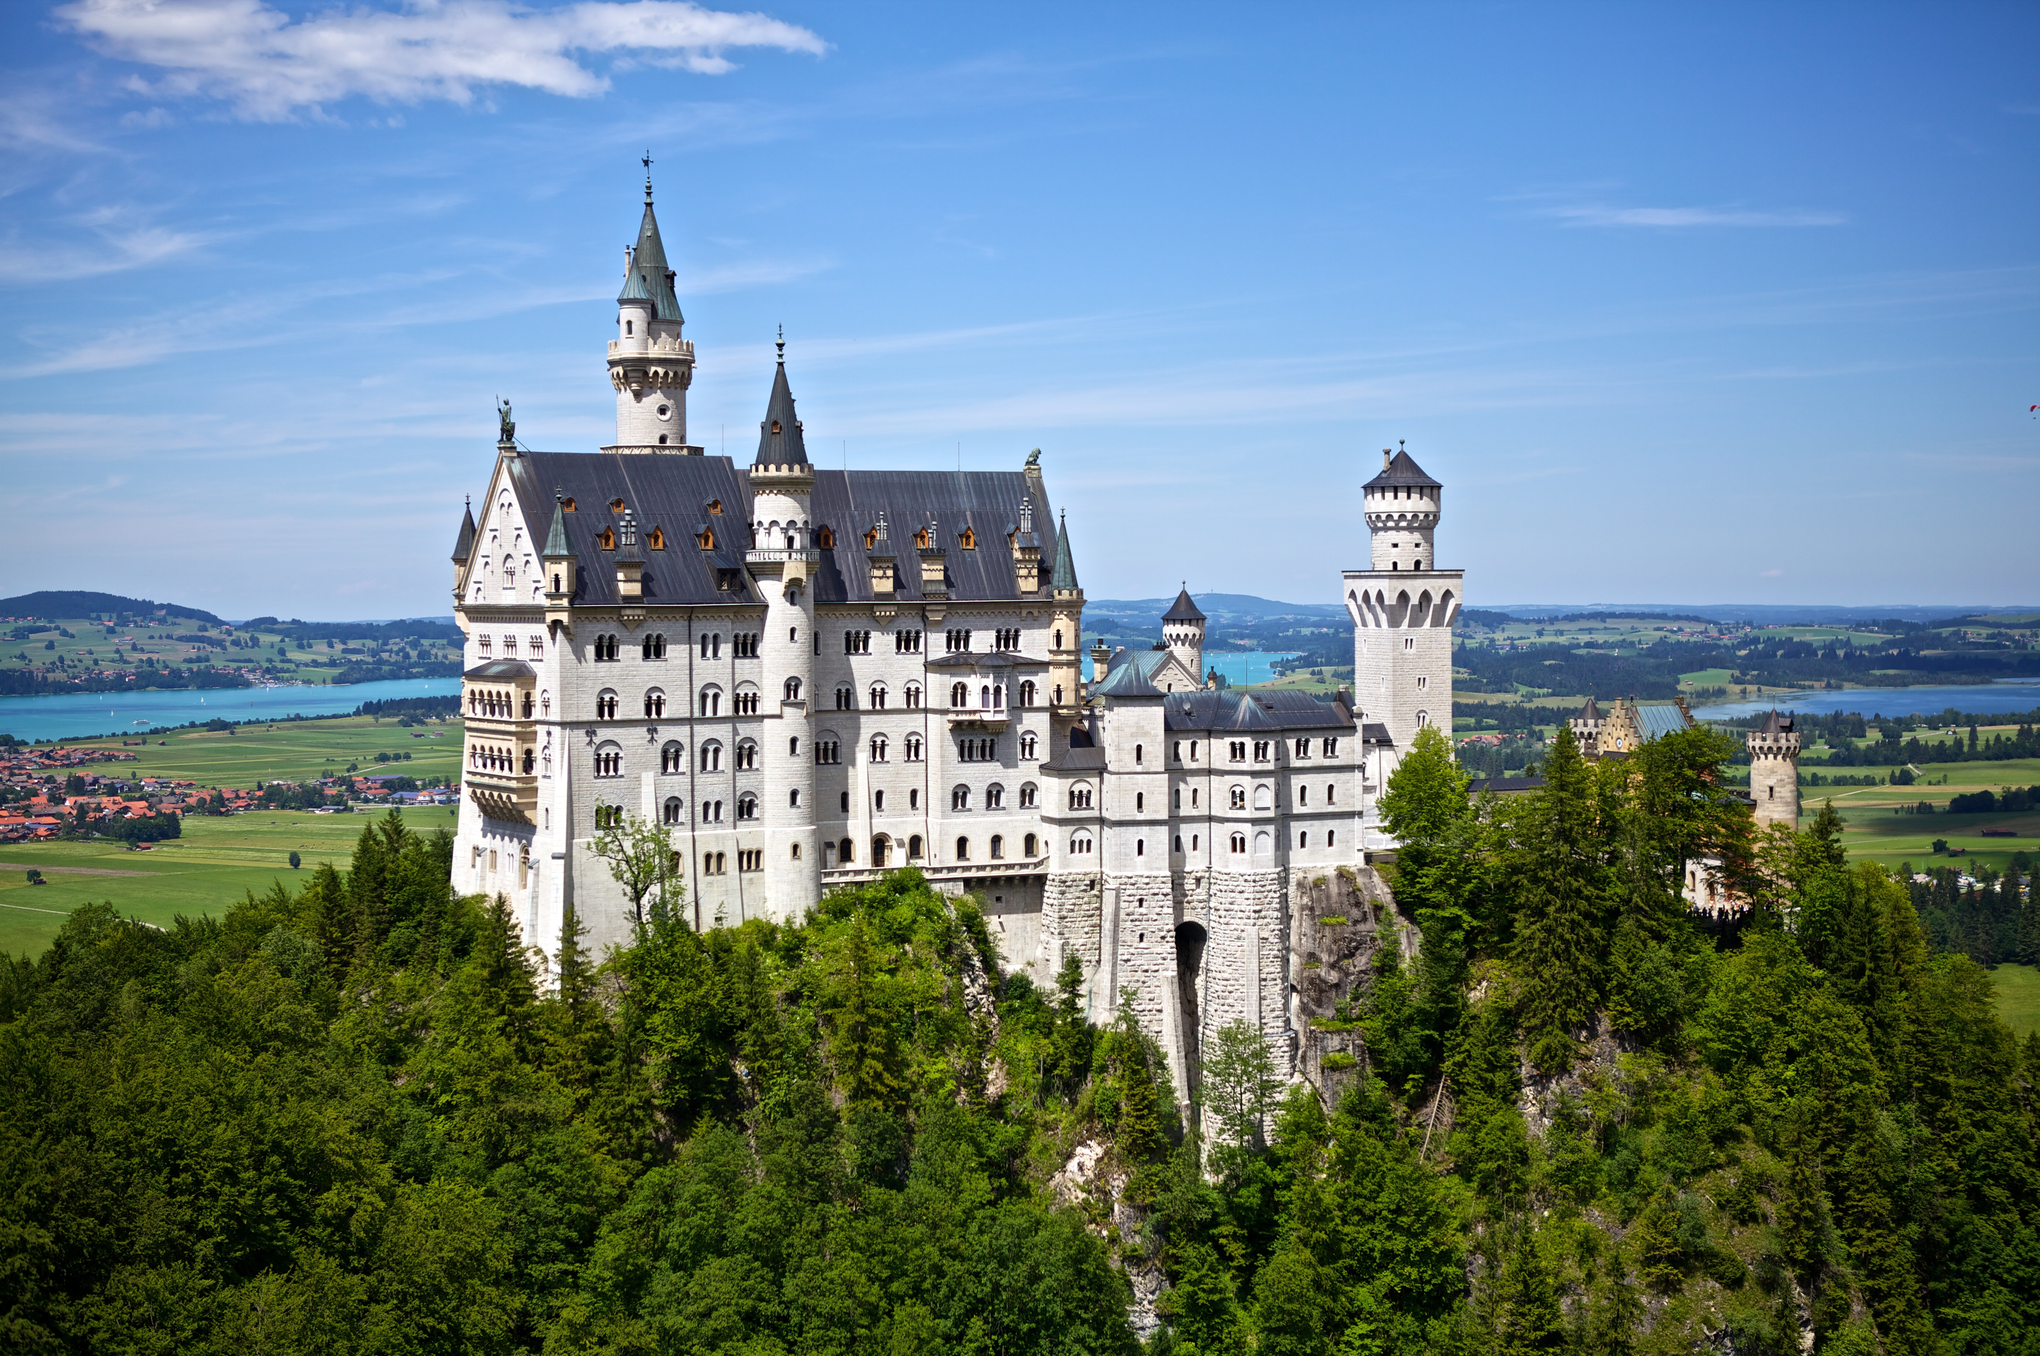

In [3]:
# Choosing image 
img = Image.open(IMG_PATH)
original_img_name = IMG_PATH.split('/')[-1]
print(f'Image dimension: {img.size}')
img

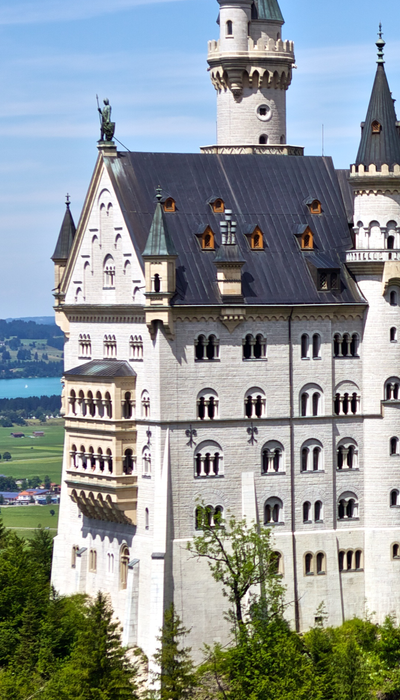

In [4]:
# Cropping chosen image to more appropriate size
crop_dim = (400, 300, 800, 1000)
img.crop(crop_dim)

In [5]:
img = img.crop(crop_dim)

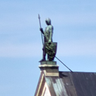

In [6]:
# Now we choose a patch 1 to test on network
patch_size = 96
x0, y0 = 58, 80
patch_dim0 = (x0, y0, x0 + patch_size, y0 + patch_size)
img.crop(patch_dim0)

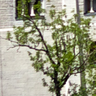

In [7]:
# Patch 2
x1, y1 = 180, 510
patch_dim1 = (x1, y1, x1 + patch_size, y1 + patch_size)
img.crop(patch_dim1)

In [8]:
def draw_border(img, clr):
    new_img = Image.new('RGB', tuple(i + 10 for i in img.size))
    ImageDraw.floodfill(new_img, xy=(0,0), value=clr)
    new_img.paste(img, (5, 5))
    return new_img

In [9]:
patch0_HR = img.crop(patch_dim0).copy()
patch1_HR = img.crop(patch_dim1).copy()

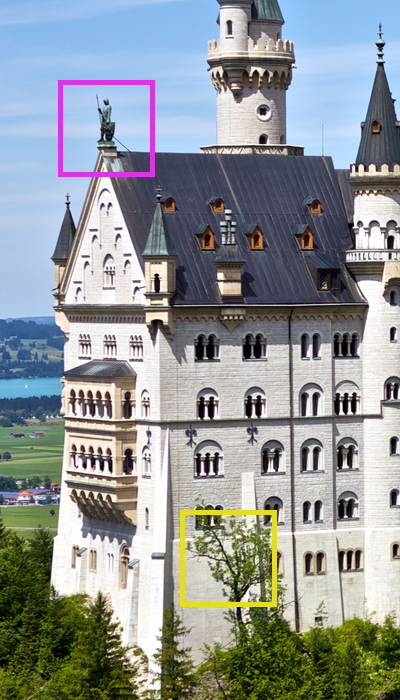

In [10]:
draw = ImageDraw.Draw(img)

draw.rectangle(
   patch_dim0,
   outline=PATCH0_COLOR,
   width=5
)
draw.rectangle(
   patch_dim1,
   outline=PATCH1_COLOR,
   width=5
)
img.save(OUTPUT_DIR + 'full.png')
img

In [11]:
generator_names = ['SRGAN', 'ESRGAN', 'MESRGAN_T2']
generator_models = [srgan, esrgan, mesrgan]
generator_trained_paths = [name + '_ALL_DATA_stage2_generator.trch' for name in generator_names]

data_mean  = [0.4439, 0.4517, 0.4054]
data_std   = [0.2738, 0.2607, 0.2856]

class Interpolate:
    def __call__(self, img):
        return F.interpolate(
            img.unsqueeze(0), 
            size=(int(patch_size/4), int(patch_size/4)), 
            mode='bicubic', 
            align_corners=False
        )
    
normalize = T.Normalize(mean=data_mean, std=data_std)

# Create HR tensor and LR
patch0_HR_tensor = T.ToTensor()(patch0_HR)
patch0_LR = Interpolate()(normalize(patch0_HR_tensor))
patch1_HR_tensor = T.ToTensor()(patch1_HR)
patch1_LR = Interpolate()(normalize(patch1_HR_tensor))

# Save the LR patches
patch0_LR_PIL = T.ToPILImage()(denormalize(patch0_LR).squeeze(0)).convert("RGB")
patch1_LR_PIL = T.ToPILImage()(denormalize(patch1_LR).squeeze(0)).convert("RGB")

patch0_LR_PIL.save(OUTPUT_DIR + 'patch0_LR.png')
patch1_LR_PIL.save(OUTPUT_DIR + 'patch1_LR.png')

In [12]:
# Save the result to file
file = open(OUTPUT_DIR + 'performance.txt', 'w')

In [13]:
# measure psnr, ssim for HR
psnr_hr = psnr(patch0_HR_tensor, patch0_HR_tensor).item()
ssim_hr = ssim_rgb(patch0_HR_tensor, patch0_HR_tensor).item()
file.write(f'HR_p0,{psnr_hr},{ssim_hr}\n')
psnr_hr = psnr(patch1_HR_tensor, patch1_HR_tensor).item()
ssim_hr = ssim_rgb(patch1_HR_tensor, patch1_HR_tensor).item()
file.write(f'HR_p1,{psnr_hr},{ssim_hr}\n')

30

In [14]:
# forward LRs through the networks and write the images to disk, together with psnr and ssim
package = zip(generator_models, generator_names, generator_trained_paths)
for model, name, model_path in package:
    generator = model.Generator()
    generator.load_state_dict(torch.load('trained_models/' + model_path))
    
    with torch.no_grad():
        output = generator(torch.cat([patch0_LR, patch1_LR], 0))
        patches_SR = denormalize(output)
    
    psnr_item0 = psnr(patch0_HR_tensor, patches_SR[0]).item()
    psnr_item1 = psnr(patch0_HR_tensor, patches_SR[1]).item()
    ssim_item0 = ssim_rgb(patch0_HR_tensor, patches_SR[0]).item()
    ssim_item1 = ssim_rgb(patch0_HR_tensor, patches_SR[1]).item()
    
    file.write(f'{name}_p0,{psnr_item0},{ssim_item0}\n')
    file.write(f'{name}_p1,{psnr_item1},{ssim_item1}\n')
    
    patch0_SR_PIL = T.ToPILImage()(patches_SR[0]).convert("RGB")
    patch0_SR_PIL.save(OUTPUT_DIR + 'patch0_SR_' + name + '.png')
    patch0_SR_PIL = draw_border(patch0_SR_PIL, PATCH0_COLOR)
    patch0_SR_PIL.save(OUTPUT_DIR + 'patch0_SR_border_' + name + '.png')
    
    patch1_SR_PIL = T.ToPILImage()(patches_SR[1]).convert("RGB")
    patch1_SR_PIL.save(OUTPUT_DIR + 'patch1_SR_' + name + '.png')
    patch1_SR_PIL = draw_border(patch1_SR_PIL, PATCH1_COLOR)
    patch1_SR_PIL.save(OUTPUT_DIR + 'patch1_SR_border_' + name + '.png')

In [15]:
file.close()

In [16]:

patch0_HR.save(OUTPUT_DIR + 'patch0_HR.png')
patch1_HR.save(OUTPUT_DIR + 'patch1_HR.png')
patch0_HR = draw_border(patch0_HR, PATCH0_COLOR)
patch1_HR = draw_border(patch1_HR, PATCH1_COLOR)
patch0_HR.save(OUTPUT_DIR + 'patch0_HR_border.png')
patch1_HR.save(OUTPUT_DIR + 'patch1_HR_border.png')